# Libraries

In [32]:
import kaggle
import pandas as pd
import numpy as np
import sidetable as stb
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from scipy.stats import spearmanr, f_oneway, ttest_ind
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression

## Libraries Settings


In [28]:
sns.set_theme(
    context='notebook',
    style='ticks',
    font_scale=.8,
    palette='colorblind',
    rc={
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.labelpad': 20,
        'axes.titlepad': 30,
    }
)

from sklearn import set_config
set_config(transform_output="pandas")

# 1. Load Data

In [3]:
# Use kaggle.api to download and unzip dataset
dataset = 'sridharstreaks/insurance-data-for-machine-learning'
kaggle.api.dataset_download_files(dataset, path='../data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning


In [4]:
# Load insurance_dataset.csv in a raw pandas DataFrame
df = pd.read_csv('../data/insurance_dataset.csv')
df.head(5)  # Show first 5 rows from DataFrame

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


# 2. Data Understanding

## 2.1. Data summary

In [5]:
# Show dataset informations
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 512.0 MB


In [6]:
# Change object dtypes to categorical
cat_cols = df.select_dtypes('object').columns.to_list()
df[cat_cols] = df[cat_cols].astype('category')

In [7]:
# Show dataset after change object to category, including memory_usage
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   age                     1000000 non-null  int64   
 1   gender                  1000000 non-null  category
 2   bmi                     1000000 non-null  float64 
 3   children                1000000 non-null  int64   
 4   smoker                  1000000 non-null  category
 5   region                  1000000 non-null  category
 6   medical_history         749238 non-null   category
 7   family_medical_history  749596 non-null   category
 8   exercise_frequency      1000000 non-null  category
 9   occupation              1000000 non-null  category
 10  coverage_level          1000000 non-null  category
 11  charges                 1000000 non-null  float64 
dtypes: category(8), float64(2), int64(2)
memory usage: 38.1 MB


In [8]:
# Show a dataset summary
df.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


## 2.2. Duplicated and Missing Values

In [9]:
# Verify if duplicated values exist
df.duplicated().any()

np.False_

In [10]:
# Check missing values
df.stb.missing()

,missing,total,percent
medical_history,250762,1000000,25.0762
family_medical_history,250404,1000000,25.0404
age,0,1000000,0.0000
gender,0,1000000,0.0000
children,0,1000000,0.0000
bmi,0,1000000,0.0000
region,0,1000000,0.0000
smoker,0,1000000,0.0000
exercise_frequency,0,1000000,0.0000
occupation,0,1000000,0.0000


<Axes: >

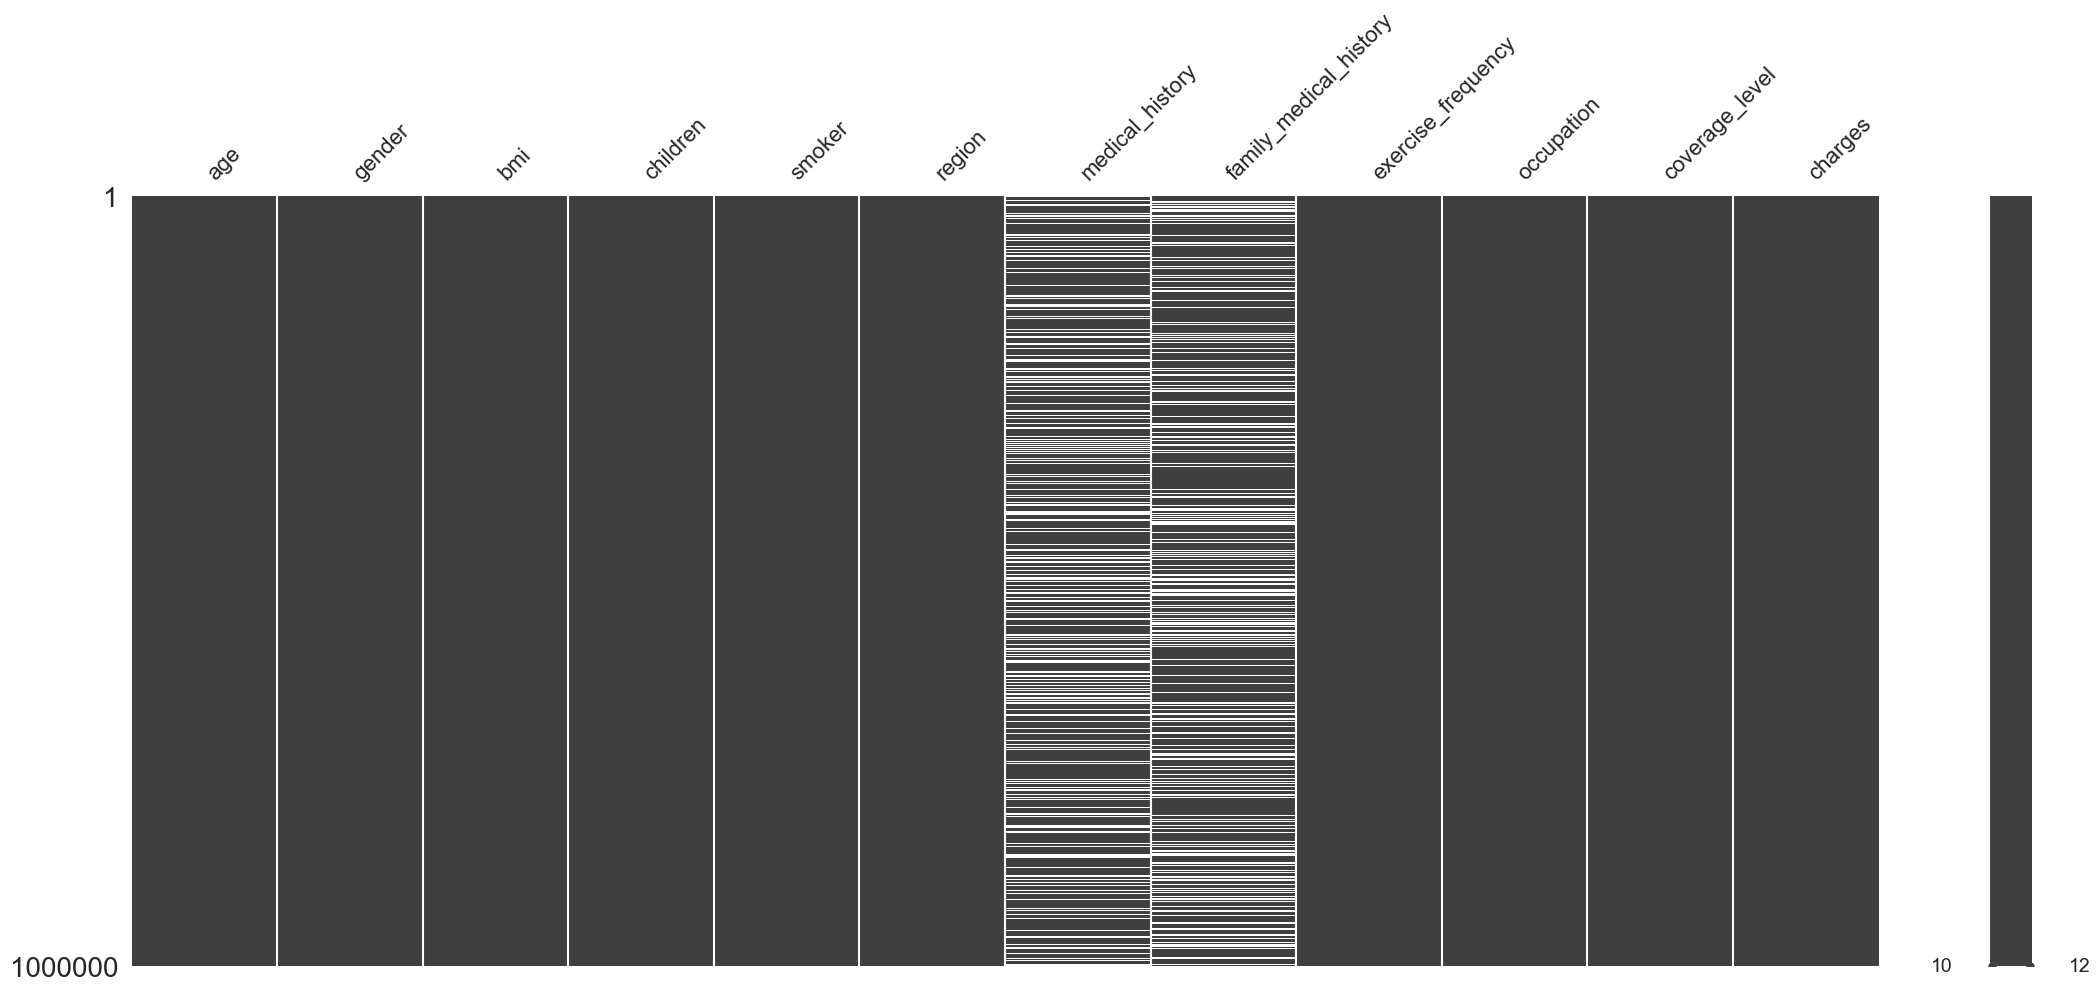

In [11]:
# Graphically check missing values
missingno.matrix(df)

## 2.3. Target distribution

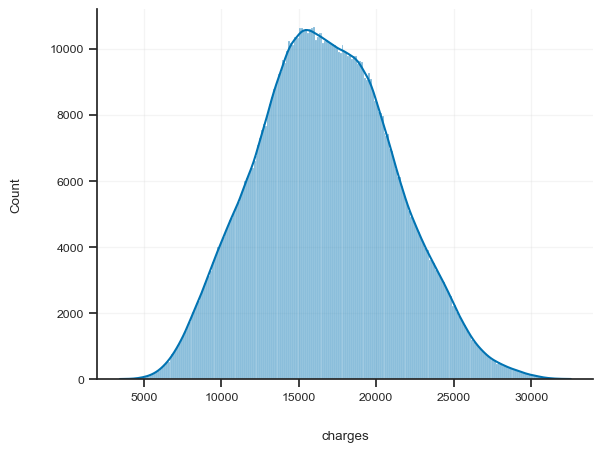

In [12]:
# Show a general charges distribution
sns.histplot(data=df, x='charges', kde=True)
sns.despine();

## 2.4. Numerical x Numerical correlation

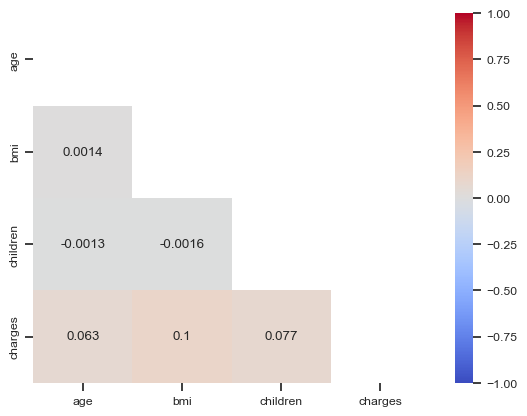

In [13]:
# Pearson correlation heatmap
num_cols = df.select_dtypes('number').columns.to_list()
pearson_r = df[num_cols].corr()
mask = np.triu(np.ones_like(pearson_r, dtype=bool))
sns.heatmap(pearson_r, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask=mask)
plt.grid(None)

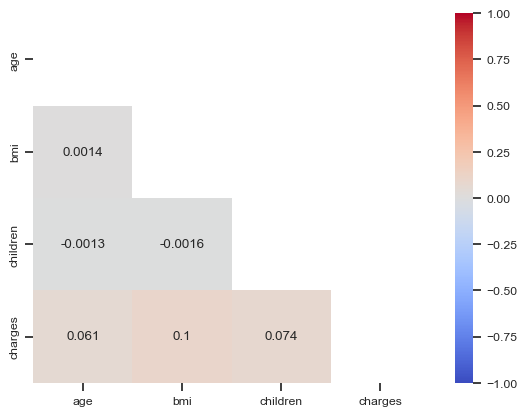

In [14]:
# Spearman correlation heatmap
spearman_rho = df[num_cols].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_rho, dtype=bool))
sns.heatmap(spearman_rho, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask=mask)
plt.grid(None)

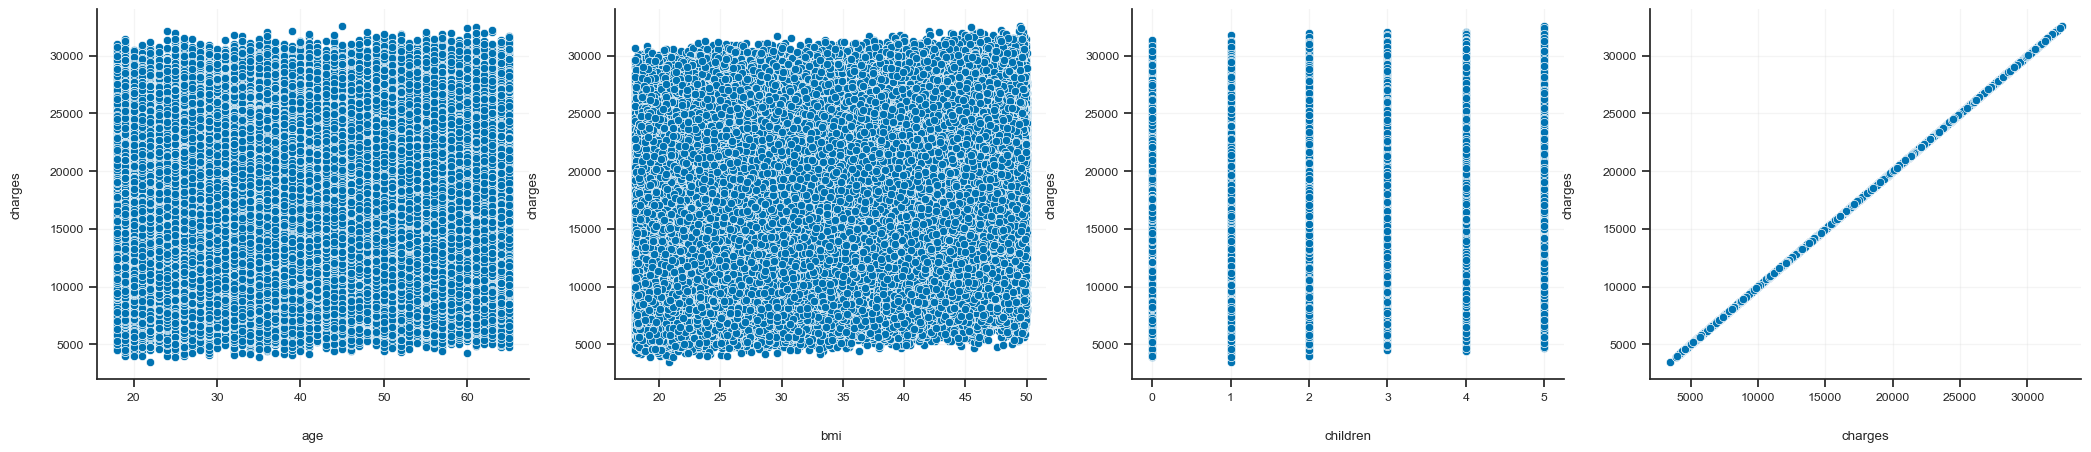

In [15]:
# Scatter plot target x numerical variables
ncols = len(num_cols)
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(6.4*ncols, 4.8))
for ax, num in zip(axes, num_cols):
    sns.scatterplot(data=df, x=num, y='charges', ax=ax)
    sns.despine()

## 2.5. Categorical x Categorical correlation

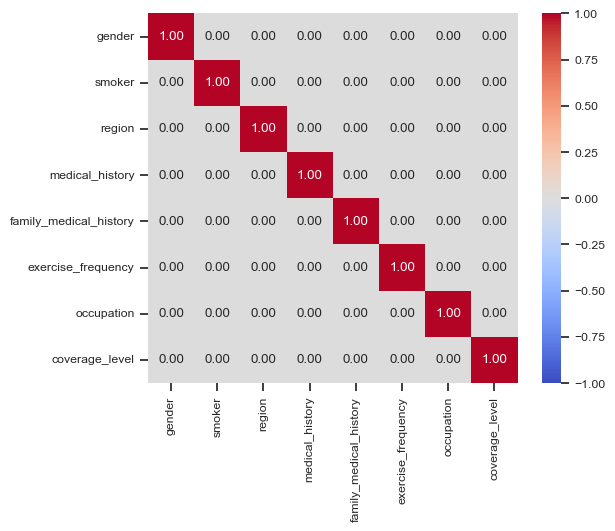

In [16]:
# Cramer's V heatmap
fig, ax = plt.subplots()
cramers_v = associations(df[cat_cols], nom_nom_assoc='cramer', ax=ax,
                         cramers_v_bias_correction=False, cmap='coolwarm',
                         vmin=-1, vmax=1)

In [17]:
associations(df[cat_cols], plot=False, nom_nom_assoc='cramer')

{'corr':                           gender    smoker    region  medical_history  \
 gender                  1.000000  0.000000  0.000733         0.000653   
 smoker                  0.000000  1.000000  0.000000         0.001856   
 region                  0.000733  0.000000  1.000000         0.000333   
 medical_history         0.000653  0.001856  0.000333         1.000000   
 family_medical_history  0.000000  0.000000  0.000000         0.000000   
 exercise_frequency      0.000000  0.002735  0.000000         0.000000   
 occupation              0.000000  0.001224  0.000000         0.001210   
 coverage_level          0.000000  0.000000  0.000000         0.000000   
 
                         family_medical_history  exercise_frequency  \
 gender                                0.000000            0.000000   
 smoker                                0.000000            0.002735   
 region                                0.000000            0.000000   
 medical_history                       0

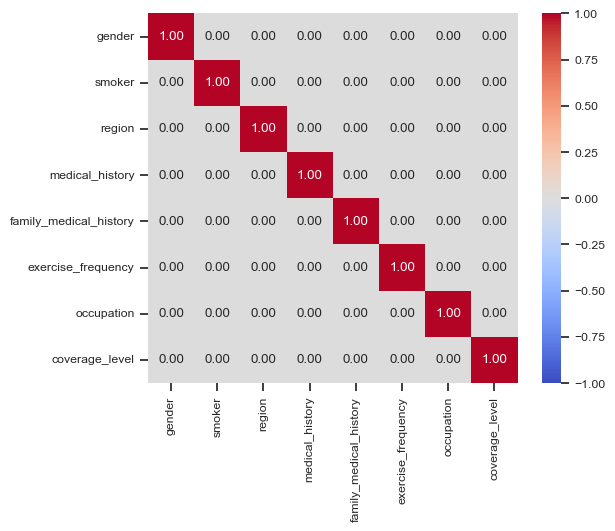

In [18]:
# Theil's U heatmap
fig, ax = plt.subplots()
cramers_v = associations(df[cat_cols], nom_nom_assoc='theil', ax=ax,
                         cmap='coolwarm',vmin=-1, vmax=1)

In [19]:
associations(df[cat_cols], plot=False, nom_nom_assoc='theil')

{'corr':                               gender        smoker    region  medical_history  \
 gender                  1.000000e+00  4.135866e-10  0.000003         0.000002   
 smoker                  4.135869e-10  1.000000e+00  0.000001         0.000005   
 region                  1.276040e-06  6.078171e-07  1.000000         0.000003   
 medical_history         1.235744e-06  2.324553e-06  0.000003         1.000000   
 family_medical_history  9.622625e-07  7.181610e-07  0.000002         0.000003   
 exercise_frequency      6.558878e-08  3.779899e-06  0.000002         0.000002   
 occupation              2.839796e-07  1.622766e-06  0.000002         0.000005   
 coverage_level          1.640107e-07  8.598664e-07  0.000002         0.000001   
 
                         family_medical_history  exercise_frequency  \
 gender                                0.000002        1.311774e-07   
 smoker                                0.000001        7.559789e-06   
 region                                

## 2.6. Categorical vs Numerical


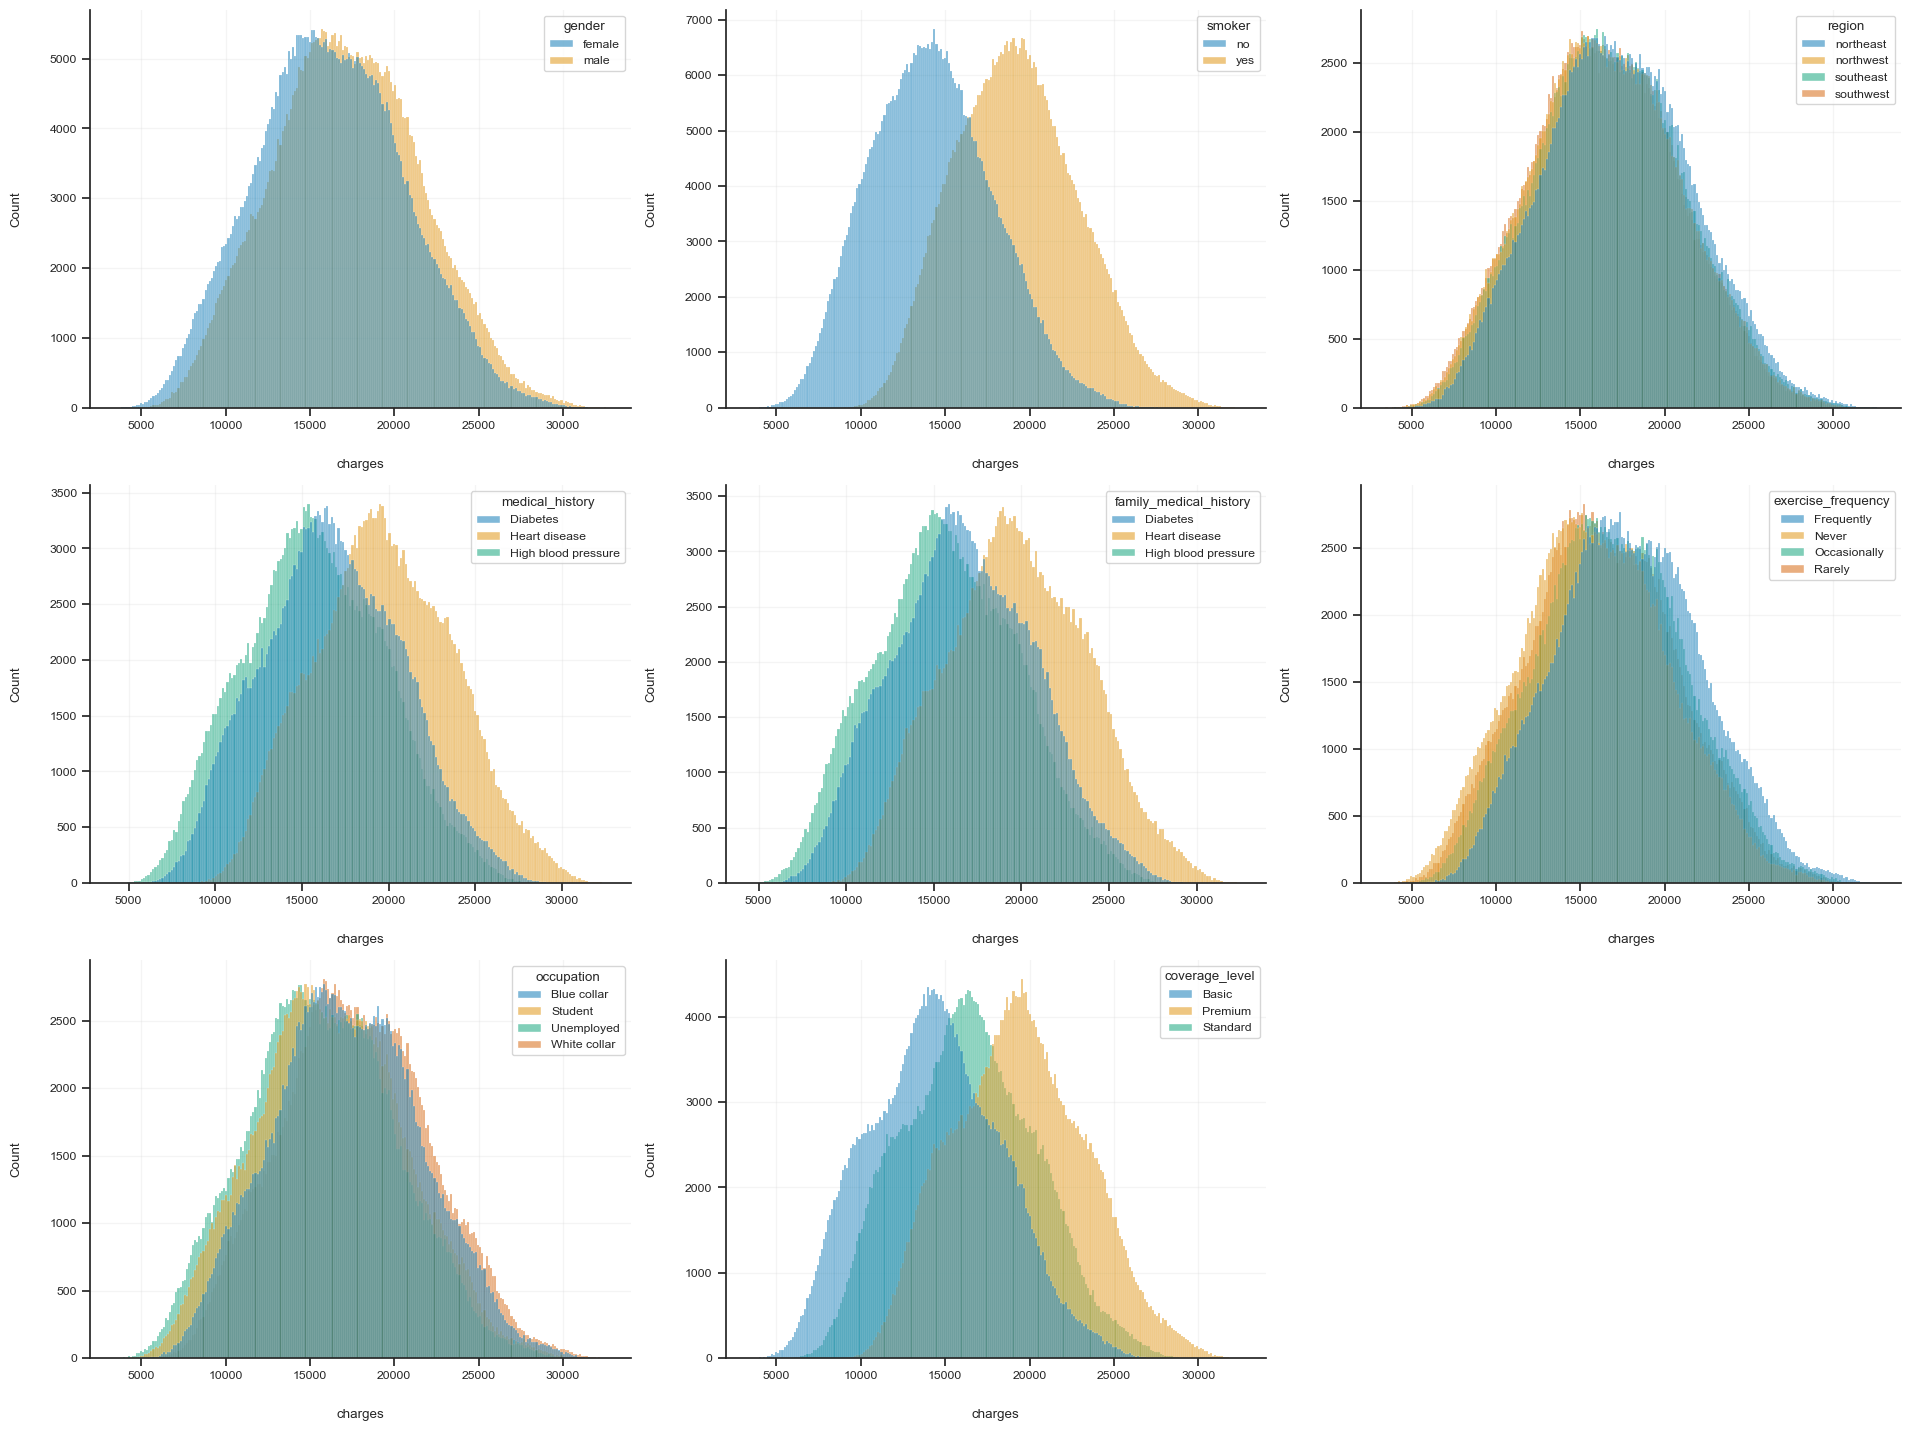

In [20]:
# Show charges distribution by categorical features
ncols = 3
nrows = int(np.ceil((len(cat_cols)) / ncols))
fig, axes = plt.subplots(figsize=(6.4*ncols, 4.8*nrows), nrows=nrows,
                         ncols=ncols)
axes = axes.flatten()
for cat, ax in zip(cat_cols, axes):
    sns.histplot(data=df, x='charges', hue=cat, ax=ax)
    sns.despine()
for ax in axes[len(cat_cols):]:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

### 2.6.1. ANOVA and T-test


In [21]:
# Creating empty dataframe with numerical features as index and categorical features as columns
df_association = pd.DataFrame(index=num_cols,
                        columns=(cat_cols))
df_association

,gender,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df['medical_history'] = df['medical_history'].cat.add_categories(['No history'])
df['family_medical_history'] = df['family_medical_history'].cat.add_categories(['No history'])
df.loc[:, 'medical_history'] = df['medical_history'].fillna('No history')
df.loc[:, 'family_medical_history'] = df['family_medical_history'].fillna('No history')


# The empty dataframe will be filled with p-values of ANOVA for features with 3 categories or more and 
# T-test for features with 2 categories
for num_col in df_association.index:
    for cat_col in df_association.columns:
        cats2compare = []
        num_cats = len(df[cat_col].unique())
        if num_cats > 2:
            for cat in df[cat_col].unique():
                cats2compare.append(df[df[cat_col] == cat][num_col])
            _, p = f_oneway(*cats2compare, nan_policy='omit')
            df_association.loc[num_col, cat_col] = p
        else:
            cat1, cat2 = df[cat_col].unique()
            _, p = ttest_ind(df[df[cat_col] == cat1][num_col],
                             df[df[cat_col] == cat2][num_col])
            df_association.loc[num_col, cat_col] = p

In [23]:
# Show associations: red (high p-value) means low association
df_association.apply(pd.to_numeric).T.style.background_gradient(cmap='Reds')

,age,bmi,children,charges
gender,0.286543,0.298562,0.498805,0.000000
smoker,0.409139,0.822040,0.908145,0.000000
region,0.556790,0.279506,0.888843,0.000000
medical_history,0.620220,0.403819,0.851380,0.000000
family_medical_history,0.896545,0.881990,0.244216,0.000000
exercise_frequency,0.824229,0.515044,0.295274,0.000000
occupation,0.759001,0.592709,0.686650,0.000000
coverage_level,0.994929,0.429358,0.513694,0.000000


## 2.7. Mutual Information

In [29]:
encoder = OrdinalEncoder()
X_cat = df[cat_cols].copy()
X_cat = encoder.fit_transform(X_cat)

X_num = df[num_cols].copy().drop(columns='charges')
X = X_cat.join(X_num)

y = df['charges'].copy()

X.head()

,gender,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,age,bmi,children
0,1.0,1.0,2.0,0.0,3.0,1.0,0.0,1.0,46,21.45,5
1,0.0,1.0,1.0,0.0,2.0,2.0,3.0,1.0,25,25.38,2
2,1.0,1.0,3.0,3.0,2.0,2.0,0.0,1.0,38,44.88,2
3,1.0,0.0,1.0,3.0,0.0,3.0,3.0,2.0,25,19.89,0
4,1.0,1.0,1.0,0.0,2.0,3.0,3.0,2.0,49,38.21,3


In [37]:
discrete_feat_array = np.hstack([
    np.repeat(True, len(cat_cols)),
    np.repeat(False, len(X_num.columns.to_list()))
])

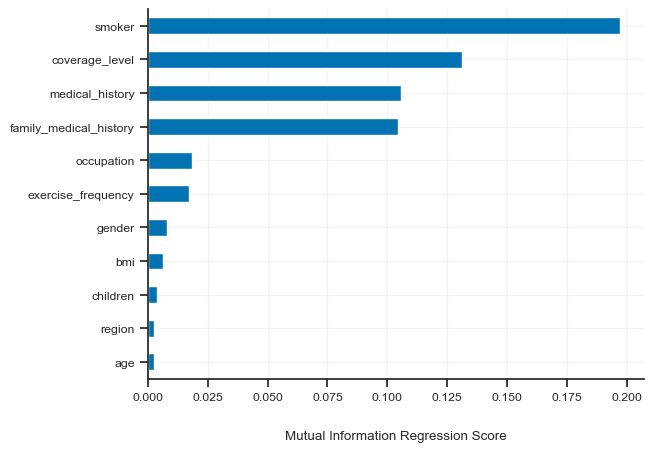

In [39]:
mi = mutual_info_regression(X, y, discrete_features=discrete_feat_array, n_neighbors=5)
pd.Series(mi, index=X.columns).sort_values(ascending=True).plot.barh()
plt.xlabel('Mutual Information Regression Score')
sns.despine()
